<a href="https://colab.research.google.com/github/jaishrm07/deep-learning-projects/blob/main/pets_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from fastai.vision.all import *
import re

In [4]:
path = untar_data(URLs.PETS)

In [5]:
# to see what's in our dataset
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [12]:
(path/"images").ls() # this returns a list of all the images in the directory "images"

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_141.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_53.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_152.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_51.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_125.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_37.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_192.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_21.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_97.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_98.jpg')...]

In [13]:
(path/"annotations").ls()

(#7) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps')]

In [20]:
fname = (path/"images").ls()[0] # this returns the name of file along with the paths
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_141.jpg')

In [22]:
re.findall(r'(.+)_\d+.jpg$', fname.name)  # to access file name from fname use fname.name

['staffordshire_bull_terrier']

### Data Block API (fastAI)

The DataBlock API allows you to define a flexible data pipeline by specifying how to load, split, label, and transform your data.

- blocks = (ImageBlock, CategoryBlock)

	•	ImageBlock: Specifies that the input data consists of images.
	•	CategoryBlock: Specifies that the labels are categorical (for classification tasks). In this case, the categories represent different pet breeds.

- get_items=get_image_files

	•	get_items: Defines how to retrieve the dataset items (in this case, images). get_image_files is a fastAI utility function that finds and returns all image files in the specified directory.

- splitter=RandomSplitter(seed=42)

	•	splitter: Defines how to split the dataset into training and validation sets. RandomSplitter splits the data randomly, and the seed=42 ensures the split is reproducible (so you get the same split every time you run the code).

- get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')

	•	get_y: Defines how to extract labels from the data. This line uses the RegexLabeller, which applies a regular expression to the filenames to extract the label. The regex r'(.+)_\d+.jpg$' captures the part of the filename before the underscore (which represents the category). The using_attr(..., 'name') tells fastAI to apply this labeler to the file’s name attribute (i.e., the filename).

- item_tfms=Resize(460)

	•	item_tfms: Defines item-level transformations. Resize(460) resizes each image to 460 pixels on the smaller edge, preserving aspect ratio. This is called presizing, which prepares the image for data augmentation while minimizing data loss (important for model performance).

- batch_tfms=aug_transforms(size=224, min_scale=0.75)

	•	batch_tfms: Defines batch-level transformations (applied after item_tfms). aug_transforms performs image augmentation, which includes a variety of transformations like flipping, zooming, and cropping. size=224 resizes the images to 224x224 pixels (after presizing), and min_scale=0.75 ensures that when zooming, at least 75% of the image is retained, minimizing image distortion.

In [27]:
# # learn about data block API of fastAI - to define custom data blocks
# The DataBlock API allows you to define a flexible data pipeline by specifying how to load, split, label, and transform your data.

pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460), # used to do presizing -- way to do image augmentation that is designed to minimize data destruction
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

'''
This line creates the DataLoaders object (dls) from the pets DataBlock.

	•	path/"images": Specifies the directory where the images are stored. The dataloaders method will:
	•	Load the images from the folder.
	•	Split the data into training and validation sets using the RandomSplitter.
	•	Apply the transformations defined in item_tfms and batch_tfms.
	•	Return a DataLoaders object, which contains the training and validation datasets, ready for model training.

'''

dls = pets.dataloaders(path/"images")

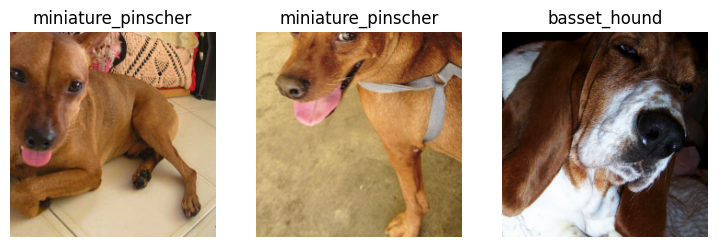

In [28]:
dls.show_batch(nrows=1, ncols=3)

In [29]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Abyssinian_176.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=400x467
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Abyssinian_176.jpg
    applying partial gives
      Abyssinian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=400x467, TensorCategory(0))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item